<a href="https://colab.research.google.com/github/mlapark/FutureMaker2021/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
# Packages for data preparation
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

from google.colab import drive
drive.mount('/content/drive')


NB_WORDS = 10000 # num of words in dictionary
NB_START_EPOCHS = 20
NB_BATCH_SIZE = 512
MAX_LEN = 20 #max words in seq

root = Path('/content/drive/My Drive/Futuremakers') #same folder it's stored in
input_path = root / 'input/'
output_path = root / 'output/'
source_path = root / 'source/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
  #fcn to train multi-class model
  #Parameters: model, training/validation features, training/val targets
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  #rmsprop - optimization method: takes avg of weights
  #read understanding RMSprop - faster NN learning link

  history = model.fit(X_train, y_train, epochs = NB_START_EPOCHS, batch_size = NB_BATCH_SIZE, validation_data = (X_valid, y_valid), verbose = 0)
  return history 

def eval_metric(model, history, metric_name):
  metric = history.history[metric_name]
  val_metric = history.history['val_'+metric_name]

  e = range(1, NB_START_EPOCHS + 1)
  plt.plot(e, metric, 'bo', label='Train '+metric_name)
  plt.plot(e, val_metric, 'b', label = 'Validation ' + metric_name)
  plt.xlabel('Epoch number')
  plt.ylabel(metric_name)
  plt.title('Comparing training and validation '+metric_name + ' for ' + model.name)
  plt.legend()
  plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
  model.fit(X_train, y_train, epochs=epoch_stop, batch_size=NB_BATCH_SIZE, verbose=0)
  results = model.evaluate(X_test)
  print()
  print('Test accuracy: {0:.2f}%'.format(results[1]*100))
  return results

def remove_stopwords(input_text): #i.e. the,a = not important, so sometimes remove it from analysis
  #trying to detect pos/neg feelings, so these words aren't imp
  stopwords_list = stopwords.words('english')
  whitelist = ["n't", "not", "no"] #i.e. won't
  words=input_text.split()
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word)>1]
  return " ".join(clean_words)

def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)

def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric): #preprocessing
  metric_model_1 = model_hist_1.history[metric]
  metric_model_2 = model_hist_2.history[metric]
  e=range(1, NB_START_EPOCHS + 1)
  metrics_dict = {
      'acc' : 'Training Accuracy',
      'loss' : 'Training Loss',
      'val_acc' : 'Validation Accuracy',
      'val_loss' : 'Validation Loss'
  }

  metric_label = metrics_dict[metric]
  plt.plot(e, metric_model_1, 'bo', label=model_1.name)
  plt.plot(e, metric_model_2, 'b', label=model_2.name)
  plt.xlabel('Epoch number')
  plt.ylabel(metric_label)
  plt.title('Comparing '+metric_label+' between models.')
  plt.legend()
  plt.show()

def optimal_epoch(model_hist):
  min_epoch = np.argmin(model_hist.history['val_loss'])+1
  print("Minimum validation loss reached in epoch{}".format(min_epoch))
  return min_epoch

In [49]:
# Data Cleaning:
# remove stopwords (nov value for predicting sentiment)

df = pd.read_csv(input_path / 'Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions) #remove stopwords & mentions

In [50]:
#Train-Test split
#scikit-learn

X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)


In [51]:
#Convert words to numbers

#apply filters and put all words to lowercase

tk = Tokenizer(num_words = NB_WORDS, filters ='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n', 
               lower=True,
               char_level=False,
               split=' ') #words separated by spaces
tk.fit_on_texts(X_train)


In [52]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')


In [53]:
le=LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

#turn 0 ([1, 0, 0]), 1 ([0, 1, 0]), 2 ([0, 0, 1]), into the vectors

In [54]:
y_test_oh

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [55]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size = 0.1, random_state=37)

In [56]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape = (NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
#base_model.name = 'Baseline model'


#**********


Minimum validation loss reached in epoch3


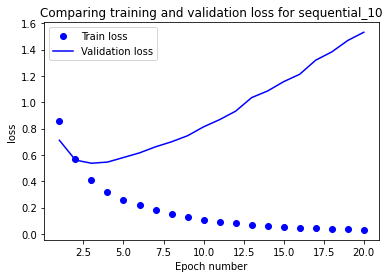

In [57]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

#this is overfitting (val loss = increasing, train loss = decreasing)

Minimum validation loss reached in epoch10


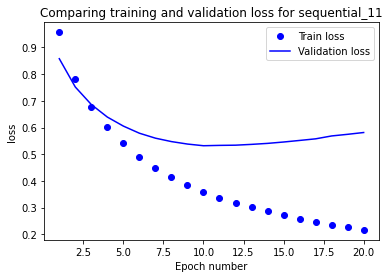

In [58]:
#Reducing the network's capacity (trying to deal with this overfitting issue)

reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
#reduced_model.name = 'Reduced model'

#******

reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)

eval_metric(reduced_model, reduced_history, 'loss')

#gap is more closer than prev graph

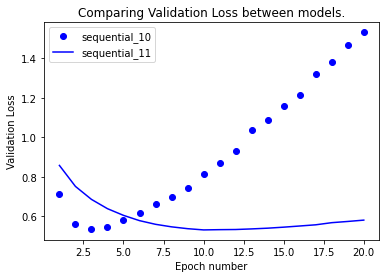

In [59]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

In [60]:
#REGULARIZATION
#L1 regularization = abs val of para
#L2 regularization = squared val of para

#L2 Regularization:

reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
#reg_model.name = 'L2 Regularization model'
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Minimum validation loss reached in epoch3


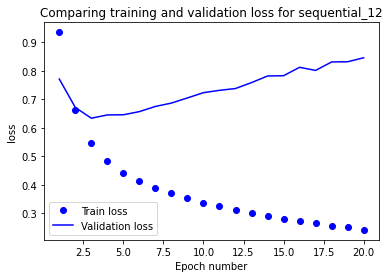

In [61]:
eval_metric(reg_model, reg_history, 'loss')


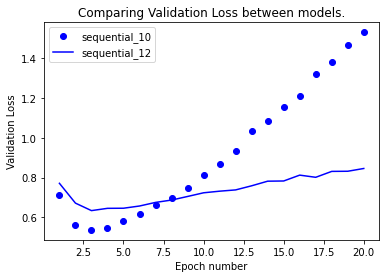

In [62]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

Minimum validation loss reached in epoch5


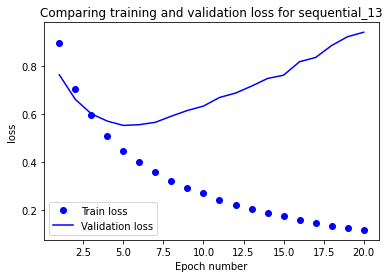

In [63]:
#Add dropout layers
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
#drop_model.name='Dropout layers model'
drop_history=deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min=optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

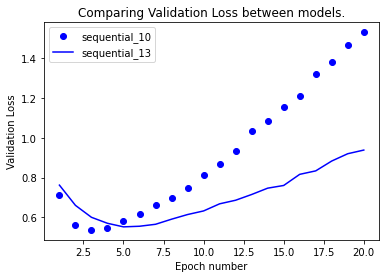

In [64]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

In [65]:
#Training on the full train data and evaluation on test data

base_results=test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results=test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results=test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results=test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

46/46 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00

Test accuracy: 0.00%
46/46 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00

Test accuracy: 0.00%
46/46 [==============================] - 0s 2ms/step - loss: 0.0953 - accuracy: 0.0000e+00

Test accuracy: 0.00%
46/46 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00

Test accuracy: 0.00%
